<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(fgsm_art.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Fast Gradient Sign Method (FGSM) using ART

### Lab objectives:    
- Learn the basics of FGSM 
- Visualize the data distribution for the adversarial examples vs the real examples   
- Look at this from a two dimension perspective   

### Step 1:   
Get the sample data   

In [1]:
# Import some libraries  
# https://embracethered.com/blog/posts/2020/husky-ai-adversarial-robustness-toolbox-testing/
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')

Torch version used:  2.7.1+cu128


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Get the toy dataset  
X, y = make_moons()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, shuffle=True)

# Get the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((75, 2), (25, 2), (75,), (25,))

In [5]:
# Convert the features to torch tensor
X_train_t = torch.tensor(X_train, dtype=torch.float, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float, device=device)

# Convert the labels to tensors
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float, device=device)
y_test_t = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float, device=device)

X_train_t.size(), y_train_t.size()

(torch.Size([75, 2]), torch.Size([75, 1]))

### Step 2:   
Setup the model   

In [6]:
# build a torch model
class MakeBlobs(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.fc1 = nn.Linear(in_features=X_train_t.size(dim=1), out_features=8, bias=True)
        self.fc2 = nn.Linear(in_features=8, out_features=1, bias=True)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
torch.manual_seed(seed=10)
model = MakeBlobs().to(device=device)
model

MakeBlobs(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)

In [7]:
# Run the model against some test data to ensure all is well
model(X_train_t[:5])

tensor([[0.4896],
        [0.5373],
        [0.4897],
        [0.4828],
        [0.4798]], device='cuda:0', grad_fn=<SigmoidBackward0>)

### Step 3:   
Setup the training loop   

In [8]:
loss_fn = nn.BCELoss()
optim = torch.optim.AdamW(model.parameters(), lr=0.11)
num_epochs = 50

for epoch in range(num_epochs):
    for p in model.parameters():
        p.grad = None
    
    y_preds = model(X_train_t)
    loss = loss_fn(input=y_preds, target=y_train_t)
    loss.backward()
    optim.step()

    accuracy = (y_preds.round() == y_train_t).sum()/y_train_t.size(dim=0)

    if epoch %10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs} \tloss: {loss} \t accuracy: {accuracy}')

Epoch: 1/50 	loss: 0.6690366268157959 	 accuracy: 0.7599999904632568
Epoch: 11/50 	loss: 0.2575102150440216 	 accuracy: 0.8799999952316284
Epoch: 21/50 	loss: 0.16351546347141266 	 accuracy: 0.9333333373069763
Epoch: 31/50 	loss: 0.1160283163189888 	 accuracy: 0.9466667175292969
Epoch: 41/50 	loss: 0.07961217314004898 	 accuracy: 0.9733333587646484


### Step 4:   
Setup the ART environment   

In [9]:
# Get the needed libraries from ART
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod

In [10]:
# Create teh ART classifier
art_clf = PyTorchClassifier(model=model, loss=loss_fn, optimizer=optim, input_shape=X_train_t.size(dim=-1), nb_classes=2, device_type=device)
art_clf

art.estimators.classification.pytorch.PyTorchClassifier(model=ModelWrapper(
  (_model): MakeBlobs(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=1, bias=True)
  )
), loss=BCELoss(), optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.11
    maximize: False
    weight_decay: 0.01
), input_shape=2, nb_classes=2, channels_first=True, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=StandardisationMeanStdPyTorch(mean=0.0, std=1.0, apply_fit=True, apply_predict=True, device=cuda:0))

### Step 5:   
Setup the ART attack and generate the adversarial examples   

In [11]:
# Create the ART attack 
aft_fgsm_attack = FastGradientMethod(estimator=art_clf, eps=0.2)

# Generate the adversarial examples
adversarial_examples = aft_fgsm_attack.generate(X_test.astype('float32'))
adversarial_examples

array([[ 0.20820999,  0.5721228 ],
       [ 1.0014136 ,  0.79811054],
       [ 0.27308324,  0.324733  ],
       [-1.19179   ,  0.32787716],
       [ 0.85463494, -0.23846842],
       [-0.2       ,  0.7       ],
       [ 0.6625383 ,  1.0865993 ],
       [ 0.60478336,  1.1144127 ],
       [ 0.7374617 , -0.1865993 ],
       [-1.0713187 ,  0.6907176 ],
       [ 1.19179   ,  0.32787716],
       [-0.77211666,  1.0201722 ],
       [ 0.23270515,  0.44634542],
       [ 0.6816074 , -0.15514277],
       [-1.0380881 ,  0.7455349 ],
       [ 0.97747904, -0.2749279 ],
       [-0.8234898 ,  0.9818315 ],
       [ 1.4723009 , -0.04027799],
       [ 1.1815592 ,  0.39115864],
       [ 1.6014136 ,  0.10188948],
       [ 0.21844085,  0.5088414 ],
       [ 0.71839255,  1.0551428 ],
       [-0.23205158,  1.1994863 ],
       [ 1.7009689 ,  0.26611626],
       [ 1.0380881 ,  0.7455349 ]], dtype=float32)

In [12]:
# compare the model's performance on the two datasets
with torch.no_grad():
    true_preds = model(X_test_t)
    adversarial_preds = model(torch.tensor(adversarial_examples, dtype=torch.float32, device=device))


    # Calculate the true accuracy
    true_accuracy = (true_preds.round() == y_test_t).sum() / y_test_t.size(dim=0)

    # Calculate the adversarial accuracy
    adversarial_accuracy = (adversarial_preds.round() == y_test_t).sum() / y_test_t.size(dim=0)


# Looks like the results is basically the same for both
# Adversarial accuracy is how many labels remain the same after we added the perturbations
true_accuracy, adversarial_accuracy

(tensor(0.9600, device='cuda:0'), tensor(0.8000, device='cuda:0'))

In [13]:
# Calculate the adversarial success rate
# This relates to how many labels were flipped from the original prediction after adding the perturbations
(true_preds != adversarial_preds).sum() / len(true_preds)

tensor(1., device='cuda:0')

Above suggest we were able to flip all the labels, thus having an adversarial success of 100%   


### Step 6:   
View the distribution of the data   

In [14]:
# Plot the results in two 
import matplotlib.pyplot as plt

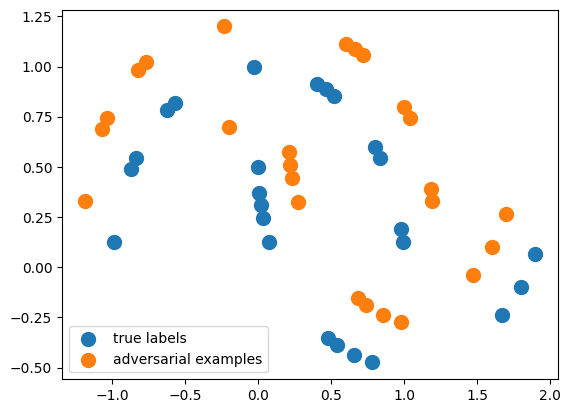

In [15]:
plt.scatter(X_test_t[:, 0].cpu(), X_test_t[:, 1].cpu(), s=100)
plt.scatter(adversarial_examples[:, 0], adversarial_examples[:, 1], s=100)

plt.legend(labels=['true labels', 'adversarial examples'])

### Lab Takeaways:   
- This was just a quick look to see what the distribution of the adversarial data looks like, when compared to the real data 